# Vacancy analysis

We want to estimate the rate of vacancy hopping, to use this as a way to
1. sanity check what is happening in the proxima "no diffusion case"
2. double-check our MSD-based diffusivity calculations
3. check that the vacancy hops follow the expected distribution, sanity checking our science in general

In [1]:
from pathlib import Path
import json
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from tqdm import tqdm
import ase
from ase.io import read

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

## Reading the data

we'll start with a full dft trajectory

In [3]:
path = Path('runs/nvt-fixed-temp/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=0-01bd9480/')

In [4]:
with open(path/'params.json') as f: 
    params = json.load(f)
params['min_target_frac'] == 1 # shows us this is a DFT-only run

True

In [5]:
params

{'file': None,
 'starting_strc': '../0_setup/initial-geometries/si-vacancy-2x2x2.vasp',
 'temperature': 1573.0,
 'timestep': 1,
 'calculator': 'lda',
 'ensemble': 'nvt',
 'temp_tau': 25,
 'stress_tau': 25.0,
 'steps': 40000,
 'seed': 8,
 'bulk_modulus': 98.0,
 'initial_volume': 1376.0,
 'model_type': 'ani',
 'initial_model': None,
 'initial_data': [],
 'ensemble_size': 2,
 'online_training': True,
 'training_epochs': 16,
 'training_batch_size': 32,
 'training_max_size': 512,
 'training_recency_bias': 1.0,
 'training_device': 'cpu',
 'target_error': 0.9,
 'error_history': 8,
 'retrain_freq': 40010,
 'min_target_frac': 1.0,
 'n_blending_steps': 0,
 'cascade_commit': '5fda70cf55730fb117bf65924cfd5fae9fd3b0ed',
 'my_commit': '5fda70cf55730fb117bf65924cfd5fae9fd3b0ed',
 'start_time': '2024-10-04T13:59:03.031129'}

In [6]:
traj = read(path/'md.traj', index=':')

In [7]:
len(traj)

40001

In [8]:
atoms = traj[0]

## Testing the vacancy estimation

First we get all of the minimum image distances

In [9]:
D = atoms.get_all_distances(mic=True)

Text(0, 0.5, 'count')

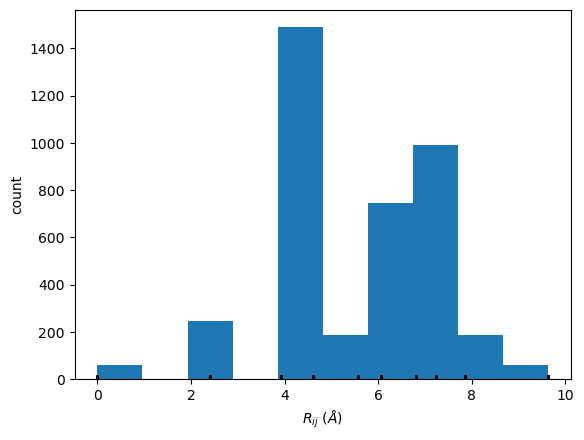

In [10]:
plt.hist(D.ravel());
plt.plot(D.ravel(), [0.1]* len(D.ravel()), '|', color='k');
plt.xlabel('$R_{ij}$ ($\AA$)')
plt.ylabel('count')

The first bin is the self distances (zero), the second bin is likely the covalently bonded Si atoms, lets see what happens if we take a cutoff just above that

In [11]:
r_cut = 3

And then find the number of neighbors

In [12]:
nn = (D < r_cut).sum(1) - 1 # subtract 1 for self distances
pd.Series(nn).value_counts()

4    59
3     4
Name: count, dtype: int64

So 59 of the atoms have 4 neighbors and 4 of them (those near the vacancy) have 3 neighbors. This seems reasonable. 

## Finding vacancy hopping

First lets bundle the code from above

In [13]:
def get_n_neighbors(atoms: ase.Atoms, r_cut: float = 3) -> np.ndarray[int]:
    D = atoms.get_all_distances(mic=True)
    nn = (D < r_cut).sum(1) - 1 # subtract 1 for self distances
    return nn

In [14]:
get_n_neighbors(atoms)

array([3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4])

And loop it over the trajectory, detecting: 

1. when the # neighbors is 'wrong' during a vacancy hop or similar
2. when the distirbution of # neighbors over atoms changes

In [15]:
correct_counts = pd.Series(nn).value_counts()
correct_counts

4    59
3     4
Name: count, dtype: int64

In [16]:
%%time
atoms = traj[0]
nn = get_n_neighbors(atoms)


# track whether a timestep has a 'wrong' or new configuration of neighbors
steps_wrong = np.zeros(len(traj))
steps_new = np.zeros(len(traj))
nn_all = [nn]

for t, atoms in enumerate(traj[1:]):
    print(f'{t}/{len(traj)}', end='\r')
    nn_new = get_n_neighbors(atoms)
    counts = pd.Series(nn_new).value_counts()

    # check whether we have the correct neighbor count distribution
    # handling the case where series comparison is invalid
    try: 
        is_correct = (counts == correct_counts).all()
    except: 
        is_correct = False
    

    # if we do have the correct neighbor count distribution
    # check if the atoms with these counts have changed
    if is_correct: 
        is_new = not (nn == nn_new).all()
        if is_new: 
            # count this as a new state
            steps_new[t] = 1
            # update the reference n_neighbor distribution
            nn = nn_new
    else: 
        steps_wrong[t] = 1

CPU times: user 21min 10s, sys: 40min 9s, total: 1h 1min 20s
Wall time: 3min 15s


In [17]:
steps_new.sum()

120.0

In [18]:
steps_wrong.sum()

15270.0

In [19]:
start = 5000
stop  = 8_000

In [20]:
t = np.arange(len(traj))

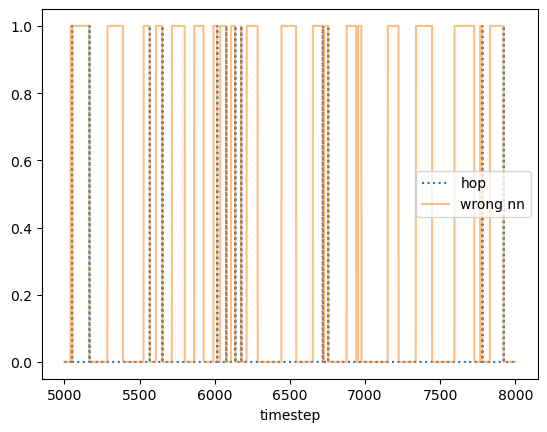

In [21]:
plt.plot(
    t[start:stop],
    steps_new[start:stop], 
    linestyle='dotted', 
    label='hop')
plt.plot(t[start:stop], 
         steps_wrong[start:stop], 
         alpha=0.5, label='wrong nn')
plt.xlabel('timestep')
plt.legend()

## Find the length of time between the hops

In [22]:
hop_indices = np.where(steps_new == 1)[0]
hop_indices

array([  133,   308,  2398,  2476,  3776,  3829,  4585,  4760,  5051,
        5167,  5568,  5652,  6017,  6077,  6137,  6177,  6719,  6755,
        7780,  7922,  8089,  8141,  8257,  8386,  8517,  8533,  9346,
        9393, 10187, 10243, 11818, 11868, 12557, 12601, 13786, 13809,
       13946, 13956, 14025, 14091, 14311, 14361, 14440, 14499, 15622,
       15658, 16941, 17051, 17246, 17288, 18476, 18529, 19985, 20036,
       20749, 21622, 21651, 21817, 21901, 23275, 23316, 23397, 23445,
       23524, 23746, 23767, 25177, 25189, 25262, 25332, 25483, 25546,
       25903, 25995, 26204, 26237, 27314, 27406, 28246, 28291, 28419,
       28542, 29302, 29373, 29412, 29606, 29643, 30443, 30532, 32205,
       32267, 32319, 32416, 32473, 32594, 32655, 32737, 32845, 33080,
       33089, 33255, 33301, 33487, 33521, 33541, 33717, 33730, 34958,
       35043, 35760, 35852, 36665, 36703, 36808, 36944, 38116, 38121,
       38175, 38655, 38738])

In [23]:
durations = np.diff(hop_indices)
durations

array([ 175, 2090,   78, 1300,   53,  756,  175,  291,  116,  401,   84,
        365,   60,   60,   40,  542,   36, 1025,  142,  167,   52,  116,
        129,  131,   16,  813,   47,  794,   56, 1575,   50,  689,   44,
       1185,   23,  137,   10,   69,   66,  220,   50,   79,   59, 1123,
         36, 1283,  110,  195,   42, 1188,   53, 1456,   51,  713,  873,
         29,  166,   84, 1374,   41,   81,   48,   79,  222,   21, 1410,
         12,   73,   70,  151,   63,  357,   92,  209,   33, 1077,   92,
        840,   45,  128,  123,  760,   71,   39,  194,   37,  800,   89,
       1673,   62,   52,   97,   57,  121,   61,   82,  108,  235,    9,
        166,   46,  186,   34,   20,  176,   13, 1228,   85,  717,   92,
        813,   38,  105,  136, 1172,    5,   54,  480,   83])

In [24]:
hop_indices[0]

133

In [25]:
np.insert(durations, 0, hop_indices[0])

array([ 133,  175, 2090,   78, 1300,   53,  756,  175,  291,  116,  401,
         84,  365,   60,   60,   40,  542,   36, 1025,  142,  167,   52,
        116,  129,  131,   16,  813,   47,  794,   56, 1575,   50,  689,
         44, 1185,   23,  137,   10,   69,   66,  220,   50,   79,   59,
       1123,   36, 1283,  110,  195,   42, 1188,   53, 1456,   51,  713,
        873,   29,  166,   84, 1374,   41,   81,   48,   79,  222,   21,
       1410,   12,   73,   70,  151,   63,  357,   92,  209,   33, 1077,
         92,  840,   45,  128,  123,  760,   71,   39,  194,   37,  800,
         89, 1673,   62,   52,   97,   57,  121,   61,   82,  108,  235,
          9,  166,   46,  186,   34,   20,  176,   13, 1228,   85,  717,
         92,  813,   38,  105,  136, 1172,    5,   54,  480,   83])

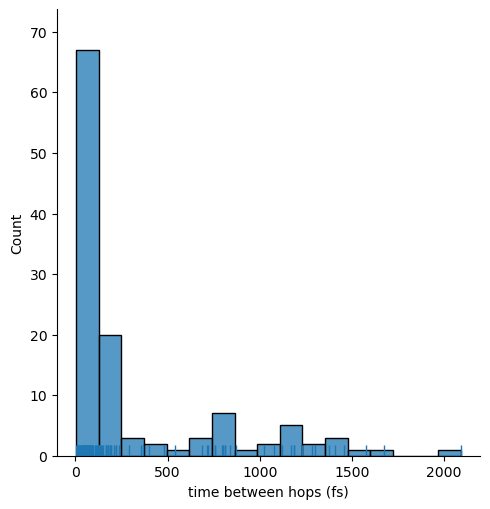

In [26]:
sns.displot(durations, rug=True)
plt.xlabel('time between hops (fs)');

That looks pretty good!

## comparing to no blending proxima:

In [27]:
cat runs/nvt-fixed-temp/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=0-526f7ee4/params.json

{
  "file": null,
  "starting_strc": "../0_setup/initial-geometries/si-vacancy-2x2x2.vasp",
  "temperature": 1573.0,
  "timestep": 1,
  "calculator": "lda",
  "ensemble": "nvt",
  "temp_tau": 25,
  "stress_tau": 25.0,
  "steps": 40000,
  "seed": 9,
  "bulk_modulus": 98.0,
  "initial_volume": 1376.0,
  "model_type": "ani",
  "initial_model": null,
  "initial_data": [],
  "ensemble_size": 2,
  "online_training": true,
  "training_epochs": 16,
  "training_batch_size": 32,
  "training_max_size": 512,
  "training_recency_bias": 1.0,
  "training_device": "cpu",
  "target_error": 0.9,
  "error_history": 8,
  "retrain_freq": 512,
  "min_target_frac": 0.1,
  "n_blending_steps": 0,
  "cascade_commit": "5fda70cf55730fb117bf65924cfd5fae9fd3b0ed",
  "my_commit": "5fda70cf55730fb117bf65924cfd5fae9fd3b0ed",
  "start_time": "2024-10-04T14:28:50.486769"
}

In [28]:
hops = np.load('runs/nvt-fixed-temp/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=0-526f7ee4/hops.npz')

In [29]:
hops['hop_indices'].shape

(212,)

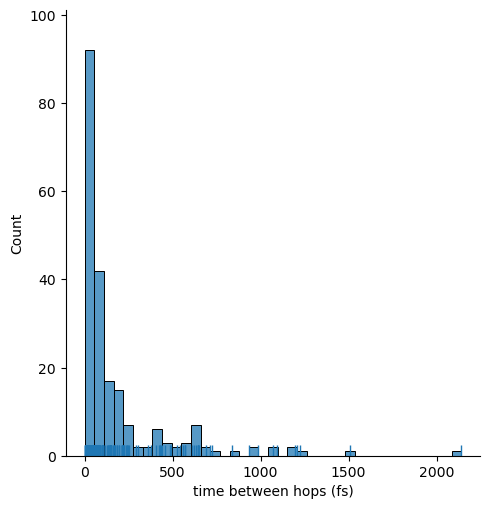

In [30]:
sns.displot(hops['durations'], rug=True)
plt.xlabel('time between hops (fs)');

## Looking at results of the script applied to all of our runs

In [31]:
from glob import glob

In [32]:
run_dirs = glob('runs/nvt-fixed-temp/si-*')

In [33]:
hops['nn_all']

array([[3, 4, 4, ..., 4, 4, 4],
       [3, 4, 4, ..., 4, 4, 4],
       [3, 4, 4, ..., 4, 4, 4],
       ...,
       [4, 4, 4, ..., 4, 4, 4],
       [3, 4, 4, ..., 4, 4, 4],
       [4, 3, 4, ..., 4, 4, 4]])

In [34]:
hops['nn_all'].shape

(213, 63)

In [35]:
df = []

for d in run_dirs:
    
    d = Path(d)
    with open(d/'params.json') as f: 
        params = json.load(f)

    hops = np.load(d/'hops.npz')
    durations = hops['durations']
    hash_ = str(d)[-8:]
    nunique = np.unique(hops['nn_all'], axis=0).shape[0]

    keep_keys = ['min_target_frac', 'n_blending_steps']
    df.append([params[k] for k in keep_keys] + [durations, hash_, params['target_error'], nunique])
df = pd.DataFrame.from_records(df, columns=keep_keys+['durations', 'hash', 'target_error', 'nunique'])

## drop the high target one!

In [79]:
df = df.query('target_error < 10')

In [80]:
df['durations'].map(lambda l:list(sorted(l)))

0     [4, 7, 11, 14, 15, 17, 18, 19, 19, 20, 21, 21,...
1     [6, 8, 12, 17, 18, 19, 19, 22, 23, 23, 26, 29,...
2     [9, 9, 11, 13, 15, 18, 18, 21, 23, 25, 27, 28,...
3     [7, 10, 16, 18, 19, 20, 20, 22, 25, 28, 34, 36...
4     [7, 8, 8, 12, 12, 14, 15, 15, 18, 21, 22, 22, ...
5     [9, 10, 13, 20, 22, 25, 26, 27, 28, 30, 30, 32...
6     [6, 8, 9, 11, 12, 12, 13, 14, 15, 15, 16, 16, ...
7     [2, 4, 8, 8, 9, 9, 9, 9, 10, 10, 10, 11, 11, 1...
8     [12, 20, 27, 31, 31, 32, 33, 33, 36, 37, 37, 3...
9     [1, 2, 4, 5, 6, 6, 6, 7, 8, 9, 10, 11, 11, 11,...
10    [5, 8, 12, 13, 15, 17, 18, 21, 22, 23, 25, 27,...
11    [5, 6, 6, 9, 9, 10, 11, 11, 11, 12, 12, 13, 13...
12    [5, 6, 6, 8, 8, 10, 10, 11, 13, 14, 15, 17, 17...
13    [13, 14, 17, 17, 18, 19, 19, 20, 21, 21, 21, 2...
14    [8, 9, 10, 13, 13, 16, 17, 17, 19, 19, 24, 24,...
15    [6, 8, 9, 15, 16, 18, 18, 19, 21, 22, 24, 24, ...
16    [5, 7, 7, 11, 13, 15, 15, 19, 19, 20, 21, 21, ...
17    [5, 5, 7, 7, 8, 8, 10, 10, 11, 12, 12, 13,

In [81]:
df['durations'].map(lambda l:len(l))

0     117
1     103
2      90
3      94
4     117
5     103
6     188
7     213
8      92
9     211
10     97
11    193
12    145
13     96
14    129
15    119
16     94
17    238
19    108
20     70
21    197
22    119
23    103
24    117
25    139
26    100
27    106
28    182
29    192
30    221
Name: durations, dtype: int64

In [82]:
df['durations'].map(sum)

0     38814
1     38834
2     37789
3     38222
4     39770
5     36692
6     39319
7     39466
8     39651
9     39553
10    38383
11    38943
12    39817
13    36975
14    39534
15    39419
16    38002
17    38907
19    39623
20    39607
21    39428
22    38605
23    35115
24    39072
25    39214
26    38796
27    39129
28    38984
29    39480
30    37520
Name: durations, dtype: int64

In [83]:
df['durations'][22].sum()

38605

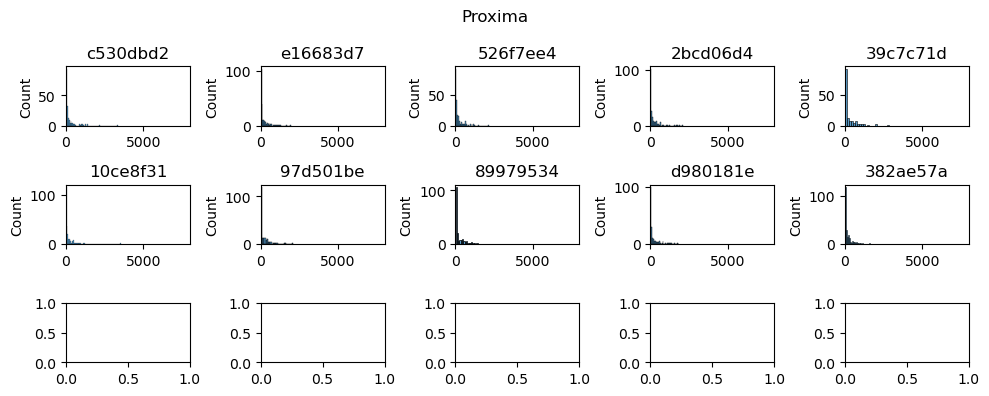

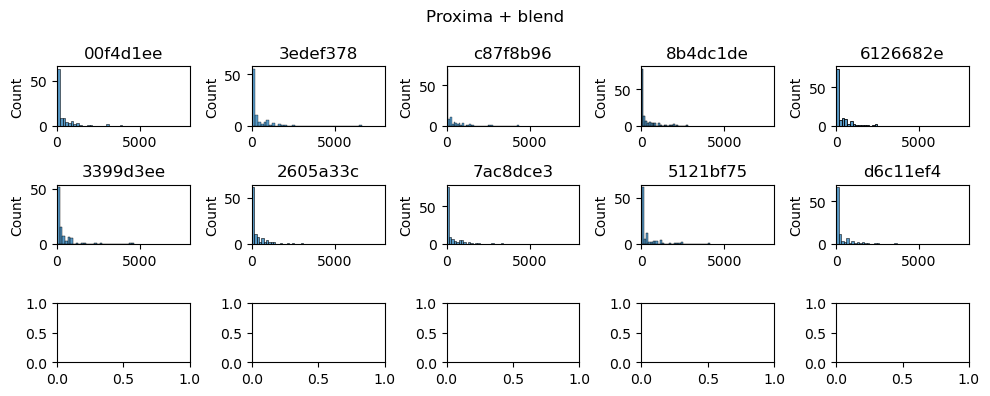

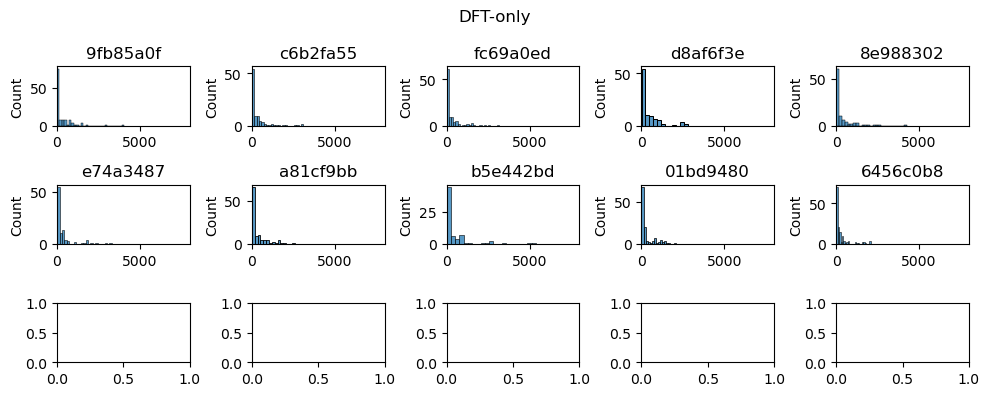

In [84]:
for (frac, n_blend), g in df.groupby(['min_target_frac', 'n_blending_steps']): 
    fig, axs = plt.subplots(3, 5, figsize=(10,4))
    for i, (_, row) in enumerate(g.iterrows()):
        ax = axs.ravel()[i]
        sns.histplot(row['durations'], ax=ax)
        ax.set_title(row['hash'])
        ax.set_xlim(0, 8000)
    if frac == 1: 
        title = 'DFT-only'
    elif n_blend == 0: 
        title = 'Proxima'
    else:
        title = 'Proxima + blend'
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

Actually, lets just combine them  

In [85]:
row

min_target_frac                                                   1.0
n_blending_steps                                                    0
durations           [38, 169, 72, 279, 18, 45, 215, 57, 387, 47, 4...
hash                                                         6456c0b8
target_error                                                      0.9
nunique                                                            69
Name: 25, dtype: object

In [86]:
new_df = []
for (frac, n_blend, t), g in df.groupby(['min_target_frac', 'n_blending_steps', 'target_error']): 
    durations = []
    nunique = []
    for i, (_, row) in enumerate(g.iterrows()):
        durations.extend(row['durations'])
        nunique.append(row['nunique'])
        
    if frac == 1: 
        title = 'DFT-only'
    elif n_blend == 0: 
        title = 'Proxima'
    elif t == 0.9:
        title = 'Proxima + blend'
    else: 
        title='Proxima + blend (high target)'
    new_df.append([title, durations, nunique])
new_df = pd.DataFrame(new_df, columns=['condition', 'duration', 'nunique'])

In [87]:
df.shape

(30, 6)

In [88]:
new_df

,condition,duration,nunique
0,Proxima,"[34, 1053, 35, 365, 53, 525, 34, 505, 29, 96, ...","[107, 110, 122, 97, 76, 123, 101, 102, 100, 116]"
1,Proxima + blend,"[86, 329, 125, 3934, 40, 907, 32, 387, 8, 19, ...","[51, 35, 65, 74, 64, 52, 53, 57, 44, 61]"
2,DFT-only,"[19, 842, 120, 21, 96, 34, 363, 77, 54, 37, 84...","[62, 39, 44, 41, 37, 37, 42, 37, 54, 69]"


In [89]:
new_df.shape

(3, 3)

In [90]:
df_long = new_df.explode('duration')

In [91]:
df_long

,condition,duration,nunique
0,Proxima,34,"[107, 110, 122, 97, 76, 123, 101, 102, 100, 116]"
0,Proxima,1053,"[107, 110, 122, 97, 76, 123, 101, 102, 100, 116]"
0,Proxima,35,"[107, 110, 122, 97, 76, 123, 101, 102, 100, 116]"
0,Proxima,365,"[107, 110, 122, 97, 76, 123, 101, 102, 100, 116]"
0,Proxima,53,"[107, 110, 122, 97, 76, 123, 101, 102, 100, 116]"
...,...,...,...
2,DFT-only,44,"[62, 39, 44, 41, 37, 37, 42, 37, 54, 69]"
2,DFT-only,769,"[62, 39, 44, 41, 37, 37, 42, 37, 54, 69]"
2,DFT-only,40,"[62, 39, 44, 41, 37, 37, 42, 37, 54, 69]"
2,DFT-only,381,"[62, 39, 44, 41, 37, 37, 42, 37, 54, 69]"


<Axes: xlabel='condition', ylabel='duration'>

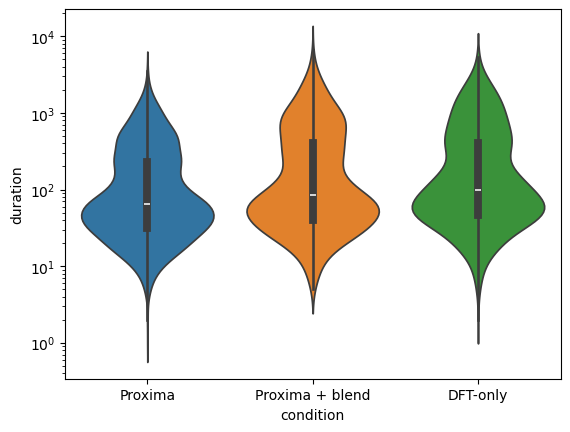

In [92]:
sns.violinplot(x='condition', 
            y='duration',
            hue='condition',
            log_scale=True,
            data=df_long)#.sample(frac=0.5))
#plt.yscale('log')

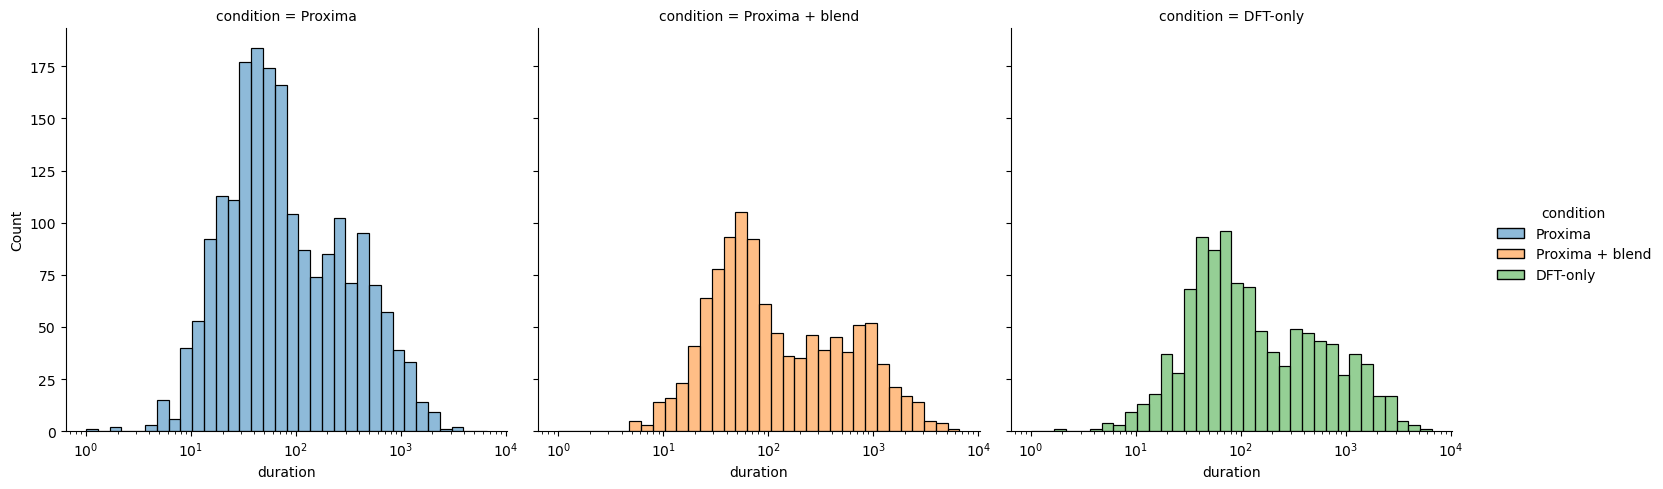

In [93]:
sns.displot(x='duration',
            col='condition',
            hue='condition',
            log_scale=(True, False),
            #rug=True,
            data=df_long)#.sample(frac=0.5))


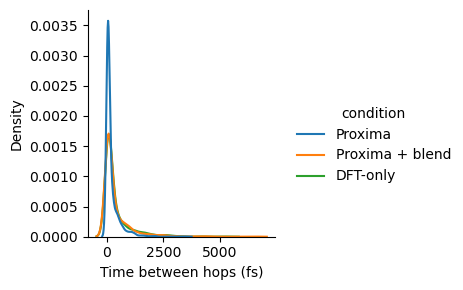

In [99]:
sns.displot(x='duration',
            #col='condition',
            hue='condition',
            log_scale=(False, False),
            #stat='percent',
            kind='kde',
            common_norm=False,
            #rug=True,
            height=3,
            aspect=1,
            data=df_long)
plt.xlabel('Time between hops (fs)')
plt.savefig('durations.png', bbox_inches='tight', dpi=500)
plt.show()

In [95]:
df_long

,condition,duration,nunique
0,Proxima,34,"[107, 110, 122, 97, 76, 123, 101, 102, 100, 116]"
0,Proxima,1053,"[107, 110, 122, 97, 76, 123, 101, 102, 100, 116]"
0,Proxima,35,"[107, 110, 122, 97, 76, 123, 101, 102, 100, 116]"
0,Proxima,365,"[107, 110, 122, 97, 76, 123, 101, 102, 100, 116]"
0,Proxima,53,"[107, 110, 122, 97, 76, 123, 101, 102, 100, 116]"
...,...,...,...
2,DFT-only,44,"[62, 39, 44, 41, 37, 37, 42, 37, 54, 69]"
2,DFT-only,769,"[62, 39, 44, 41, 37, 37, 42, 37, 54, 69]"
2,DFT-only,40,"[62, 39, 44, 41, 37, 37, 42, 37, 54, 69]"
2,DFT-only,381,"[62, 39, 44, 41, 37, 37, 42, 37, 54, 69]"


In [96]:
df_long['rate'] = 1/df_long['duration']

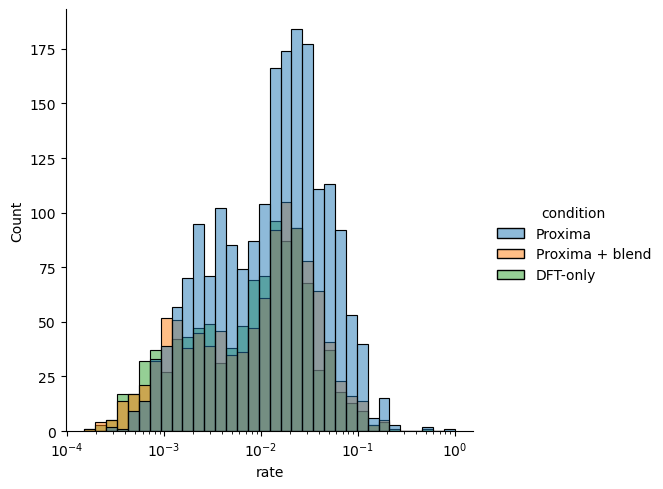

In [97]:
sns.displot(x='rate', 
            hue='condition',
            log_scale=(True, False),
            data=df_long)

In [98]:
df_long

,condition,duration,nunique,rate
0,Proxima,34,"[107, 110, 122, 97, 76, 123, 101, 102, 100, 116]",0.029412
0,Proxima,1053,"[107, 110, 122, 97, 76, 123, 101, 102, 100, 116]",0.00095
0,Proxima,35,"[107, 110, 122, 97, 76, 123, 101, 102, 100, 116]",0.028571
0,Proxima,365,"[107, 110, 122, 97, 76, 123, 101, 102, 100, 116]",0.00274
0,Proxima,53,"[107, 110, 122, 97, 76, 123, 101, 102, 100, 116]",0.018868
...,...,...,...,...
2,DFT-only,44,"[62, 39, 44, 41, 37, 37, 42, 37, 54, 69]",0.022727
2,DFT-only,769,"[62, 39, 44, 41, 37, 37, 42, 37, 54, 69]",0.0013
2,DFT-only,40,"[62, 39, 44, 41, 37, 37, 42, 37, 54, 69]",0.025
2,DFT-only,381,"[62, 39, 44, 41, 37, 37, 42, 37, 54, 69]",0.002625


## Make the table

In [55]:
means = df_long.groupby('condition')['duration'].mean().astype(float)#.reset_index()
means

condition
DFT-only                         372.740097
Proxima                          197.685354
Proxima + blend                  357.569573
Proxima + blend (high target)    793.562500
Name: duration, dtype: float64

In [56]:
rates = 1/means
rates

condition
DFT-only                         0.002683
Proxima                          0.005059
Proxima + blend                  0.002797
Proxima + blend (high target)    0.001260
Name: duration, dtype: float64

In [57]:
se_means = means / np.sqrt(df_long.query('condition != "Proxima (bad params)"').groupby('condition')['duration'].size())
se_means 

condition
DFT-only                          11.586064
Proxima                            4.442648
Proxima + blend                   10.890584
Proxima + blend (high target)    198.390625
Name: duration, dtype: float64

In [58]:
se_rates = rates * (se_means / means) # check with logan that I did this UQ propagation correctly

In [59]:
table = pd.DataFrame({'rate': rates, 'se': se_rates})
table *= 1000 # Convert to THz (1/ps) (we had 1/fs = PHz)
table

,rate,se
condition,,
DFT-only,2.682835,0.083392
Proxima,5.058544,0.113682
Proxima + blend,2.796659,0.085179
Proxima + blend (high target),1.260140,0.315035


In [60]:
print(table.to_latex())

\begin{tabular}{lrr}
\toprule
 & rate & se \\
condition &  &  \\
\midrule
DFT-only & 2.682835 & 0.083392 \\
Proxima & 5.058544 & 0.113682 \\
Proxima + blend & 2.796659 & 0.085179 \\
Proxima + blend (high target) & 1.260140 & 0.315035 \\
\bottomrule
\end{tabular}



In [61]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [62]:
df_long

,condition,duration,nunique,rate
0,Proxima,34,"[107, 110, 122, 97, 76, 123, 101, 102, 100, 116]",0.029412
0,Proxima,1053,"[107, 110, 122, 97, 76, 123, 101, 102, 100, 116]",0.00095
0,Proxima,35,"[107, 110, 122, 97, 76, 123, 101, 102, 100, 116]",0.028571
0,Proxima,365,"[107, 110, 122, 97, 76, 123, 101, 102, 100, 116]",0.00274
0,Proxima,53,"[107, 110, 122, 97, 76, 123, 101, 102, 100, 116]",0.018868
...,...,...,...,...
3,DFT-only,44,"[62, 39, 44, 41, 37, 37, 42, 37, 54, 69]",0.022727
3,DFT-only,769,"[62, 39, 44, 41, 37, 37, 42, 37, 54, 69]",0.0013
3,DFT-only,40,"[62, 39, 44, 41, 37, 37, 42, 37, 54, 69]",0.025
3,DFT-only,381,"[62, 39, 44, 41, 37, 37, 42, 37, 54, 69]",0.002625


In [63]:
df_long['duration'] = df_long['duration'].astype(int)

In [64]:
df_long['condition'] = pd.Categorical(df_long['condition'])

In [65]:
formula = 'duration ~ C(condition)'

In [66]:
mod1 = smf.glm(formula=formula, data=df_long, family=sm.families.Poisson()).fit()
print(mod1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               duration   No. Observations:                 4109
Model:                            GLM   Df Residuals:                     4105
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0336e+06
Date:                Thu, 01 May 2025   Deviance:                   2.0406e+06
Time:                        17:56:31   Pearson chi2:                 3.33e+06
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

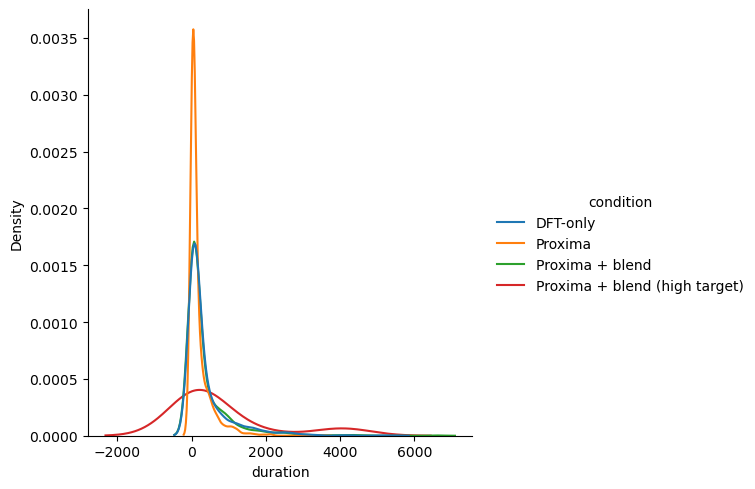

In [67]:
sns.displot(x='duration',
            #col='condition',
            hue='condition',
            log_scale=(False, False),
            #rug=True,
            common_norm=False,
            kind='kde',
            data=df_long.query('condition != "Proxima (bad params)"'))


<Axes: xlabel='duration'>

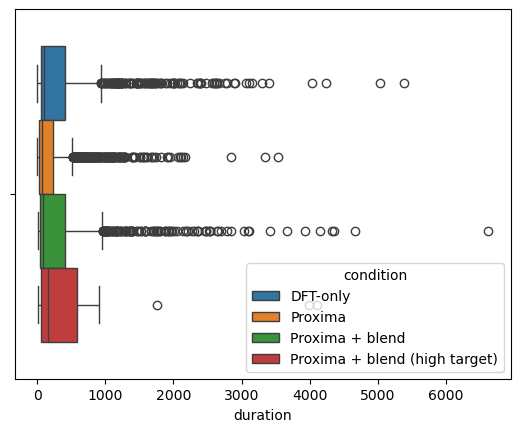

In [68]:
sns.boxplot(x='duration',
            #col='condition',
            hue='condition',
            log_scale=(False, False),
            #rug=True,
            #common_norm=False,
            #kind='kde',
            data=df_long.query('condition != "Proxima (bad params)"'))


In [69]:
df_long

,condition,duration,nunique,rate
0,Proxima,34,"[107, 110, 122, 97, 76, 123, 101, 102, 100, 116]",0.029412
0,Proxima,1053,"[107, 110, 122, 97, 76, 123, 101, 102, 100, 116]",0.00095
0,Proxima,35,"[107, 110, 122, 97, 76, 123, 101, 102, 100, 116]",0.028571
0,Proxima,365,"[107, 110, 122, 97, 76, 123, 101, 102, 100, 116]",0.00274
0,Proxima,53,"[107, 110, 122, 97, 76, 123, 101, 102, 100, 116]",0.018868
...,...,...,...,...
3,DFT-only,44,"[62, 39, 44, 41, 37, 37, 42, 37, 54, 69]",0.022727
3,DFT-only,769,"[62, 39, 44, 41, 37, 37, 42, 37, 54, 69]",0.0013
3,DFT-only,40,"[62, 39, 44, 41, 37, 37, 42, 37, 54, 69]",0.025
3,DFT-only,381,"[62, 39, 44, 41, 37, 37, 42, 37, 54, 69]",0.002625


In [70]:
df_long = new_df.explode('nunique')

<Axes: xlabel='condition', ylabel='nunique'>

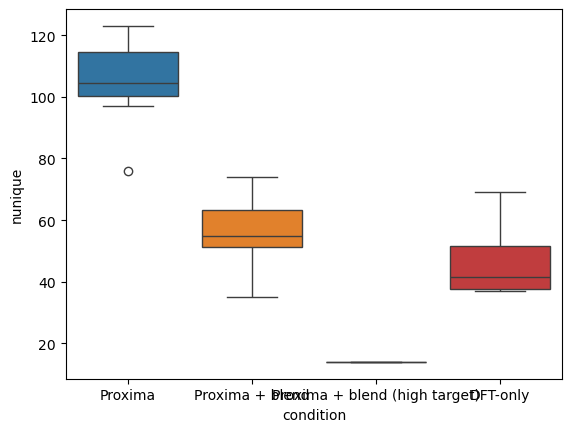

In [71]:
sns.boxplot(data=df_long,x='condition', hue='condition', y='nunique')

<Axes: xlabel='condition', ylabel='nunique'>

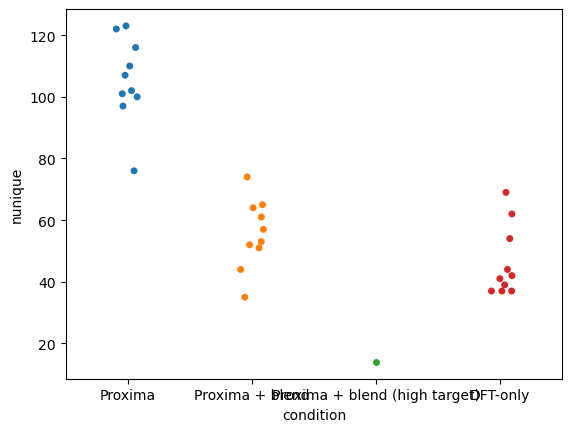

In [72]:
sns.stripplot(data=df_long,x='condition', hue='condition', y='nunique')

Another plot we could have: write down the hop rate of each duration. this would make it much more clear that there are very few long hops in proxima and many short hops -- the dynamics are bad. or we can still vote table. 

the frequency of occurence as the y axis.

In [73]:
hops_bad = np.load('runs/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=10-4065eb7d/hops.npz')
durations_bad = hops_bad['durations']
nunique_bad = np.unique(hops_bad['nn_all'], axis=0).shape[0]

In [74]:
df_long

,condition,duration,nunique
0,Proxima,"[34, 1053, 35, 365, 53, 525, 34, 505, 29, 96, ...",107
0,Proxima,"[34, 1053, 35, 365, 53, 525, 34, 505, 29, 96, ...",110
0,Proxima,"[34, 1053, 35, 365, 53, 525, 34, 505, 29, 96, ...",122
0,Proxima,"[34, 1053, 35, 365, 53, 525, 34, 505, 29, 96, ...",97
0,Proxima,"[34, 1053, 35, 365, 53, 525, 34, 505, 29, 96, ...",76
0,Proxima,"[34, 1053, 35, 365, 53, 525, 34, 505, 29, 96, ...",123
0,Proxima,"[34, 1053, 35, 365, 53, 525, 34, 505, 29, 96, ...",101
0,Proxima,"[34, 1053, 35, 365, 53, 525, 34, 505, 29, 96, ...",102
0,Proxima,"[34, 1053, 35, 365, 53, 525, 34, 505, 29, 96, ...",100
0,Proxima,"[34, 1053, 35, 365, 53, 525, 34, 505, 29, 96, ...",116


In [75]:
df_long= pd.concat([df_long, 
           pd.DataFrame([['Proxima (bad params)', d, None, None] for d in durations_bad], 
             columns=['condition', 'duration', 'nunique', 'rate'])
          ], 
          ignore_index=True)

TypeError: unhashable type: 'list'

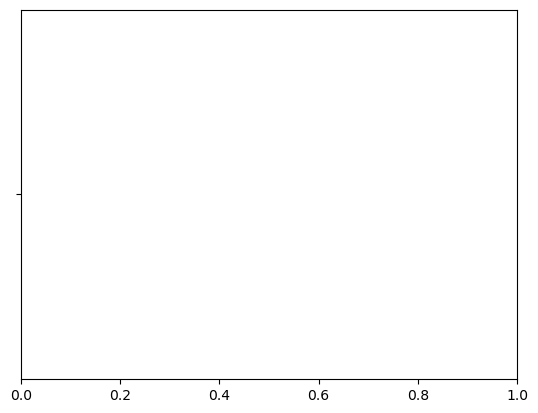

In [76]:
sns.boxplot(x='duration',
            #col='condition',
            hue='condition',
            #log_scale=(True, False),
            #rug=True,
            #common_norm=False,
            #kind='kde',
            data=df_long)


## params

In [ ]:
run_dirs = sorted(glob('runs/nvt-fixed-temp/*si-vacancy*'))
run_dirs

In [ ]:
params = []
for d in run_dirs:
    try:
        params.append(json.loads((Path(d)/'params.json').read_text()))
    except: 
        print(f'couldnt find {d}/params.json; skipping')
        continue
    params[-1]['dir'] = d
params = pd.DataFrame(params)

In [ ]:
param_vars = ['seed', 'temperature', 'n_blending_steps', 'min_target_frac', 'target_error', 'stress_tau', 'steps']

In [ ]:
data = []
hashes = []
for i, row in params.iterrows(): 
    # read in the results for each set of parameters
    run = row['dir']
    try:
        _data = pd.read_json(Path(run)/'proxima-log.json', lines=True)
    except: 
        print('couldnt read proximal log for', run)
        hashes.append(None)
        continue
    # make sure to have timestep
    _data.reset_index(names='timestep', inplace=True)

    # keep the hash of the run
    _hash = run.split('-')[-1]
    hashes.append(_hash)
    _data['hash'] = _hash 
    #traj = read(Path(run)/'md.traj', index=':')
    #break    
    # add the parameters to the experiment df for easy plotting, grouping, etc
    for var in param_vars:
        _data[var] = row[var]
    data.append(_data)

# track the hashes as well for param lookup
params['hash'] = hashes
data = pd.concat(data)

In [ ]:
data['full_surrogate'] = (data['proxima_blending_step'] == data['n_blending_steps']) & data['used_surrogate']

In [ ]:
stuff = []
for _hash, g  in data.groupby('hash'): 
    frac = g['full_surrogate'].mean()
    stuff.append((_hash, frac))
stuff = pd.DataFrame.from_records(stuff, columns=['hash', 'full_surrogate'])
params = pd.merge(params, stuff, on='hash')

In [ ]:
g = sns.catplot(x='n_blending_steps',
                hue='n_blending_steps',
            col='min_target_frac', 
            row='target_error',
            y='full_surrogate',
            data=params,
            sharey=False,
            sharex=False)
plt.show()

In [ ]:
data_trained = data.loc[data['model_version'] > 0]

In [ ]:
((data_trained['last_uncer'] > data_trained['proxima_threshold']) & ~data_trained['used_surrogate']).mean()

In [ ]:
data_trained.loc[:, 'over_thresh'] = (data_trained['last_uncer'] > data_trained['proxima_threshold'])

In [ ]:
data_trained.loc[:, 'audited'] = ~data_trained['used_surrogate'] & ~data_trained['over_thresh']

In [ ]:
data_trained['audited'].mean()

In [ ]:
data_trained.loc[:, 'within_target'] = data_trained['last_error'] < data_trained['target_error']

In [ ]:
data_trained['within_target'].mean()

In [ ]:
data_trained['positive_audit'] = (data_trained['audited'] & ~data_trained['within_target'])

In [ ]:
data_trained['positive_thresh'] = data_trained['over_thresh'] & ~data_trained['within_target']

In [ ]:
positive_rates = data_trained.groupby('hash')[['positive_thresh', 'positive_audit']].mean().reset_index()

In [ ]:
params = pd.merge(params, positive_rates, how='left', on='hash')

In [ ]:
g = sns.catplot(x='n_blending_steps',
                hue='n_blending_steps',
            col='min_target_frac', 
            row='target_error',
            y='positive_audit',
            data=params,
            sharey=False,
            sharex=False)
plt.show()

In [ ]:
g = sns.catplot(x='n_blending_steps',
                hue='n_blending_steps',
            col='min_target_frac', 
            row='target_error',
            y='positive_thresh',
            data=params,
            sharey=False,
            sharex=False)
plt.show()